# 02 - Preprocessing & Feature Engineering

This notebook continues from **01_data_eda.ipynb**.  
The dataset has already been cleaned, explored, and saved in a processed form.  
Here, I focus on:
- Preprocessing (handling missing values, encoding, scaling, splits)
- Feature engineering (derived features, interactions, transformations)
- Preparing data for modeling

## Introduction
I begin this notebook by loading the processed dataset from the EDA phase. The EDA identified key insights, feature selections, and potential engineering opportunities, which I will now implement. My goal is to transform the data into a modeling-ready format, ensuring robust preprocessing and meaningful feature enhancements.

## Loading Data
I load the cleaned dataset saved from the EDA notebook, verifying its structure and integrity before proceeding with further steps.

## Preprocessing Steps
- **Missing Values**: I confirm no significant missing data remains post-EDA imputation (e.g., `totalcharges` median fill).
- **Encoding Categorical Variables**: I apply one-hot encoding to categorical features (e.g., `contract`, `internetservice`) and label encoding where appropriate.
- **Scaling Numerical Features**: I standardize `tenure` and `monthlycharges` using StandardScaler to normalize their ranges.
- **Train-Test Split**: I split the data into training (80%) and testing (20%) sets, ensuring stratification on `churn` to maintain class balance.

## Feature Engineering
- **Derived Features**: I create `total_services` by summing binary service columns (e.g., `onlinesecurity`, `techsupport`, `multiplelines` before drop).
- **Interaction Terms**: I explore interactions (e.g., `tenure` × `contract`) to capture combined effects.
- **Transformations**: I consider log transformation for skewed features if needed post-scaling.
- **Feature Drop**: I finalize dropping `multiplelines` (low MI: 0.000801) and implement an `has_internet` indicator based on EDA insights for "No Internet Service" stability.

## Validation and Output
I validate transformations (e.g., check encoded shapes, scaled distributions) and save the preprocessed dataset for modeling in the next notebook.

## Next Steps
- Proceed to modeling notebook for algorithm selection, training, and evaluation.

### Importing Required Libraries

In [127]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_classif
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import accuracy_score, precision_recall_curve, confusion_matrix, classification_report, roc_auc_score, auc, average_precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

import joblib
import shap
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module="tqdm")

### Loading Cleaned Data

In [94]:
df = pd.read_csv("cleaned_heartdisease_data.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
## Preview
df.head()

,seniorcitizen,partner,dependents,tenure,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,churn,tenure_group,MC_group
0,0,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,0,0-12 Months,Low
1,0,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,0,25-48 Months,Mid
2,0,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,1,0-12 Months,Mid
3,0,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,0,25-48 Months,Low
4,0,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,1,0-12 Months,Mid


In [95]:
df.shape

(7043, 19)

## Feature Engineering

### `has_internet` binary feature

In [100]:
df['has_internet'] = df['internetservice'].apply(lambda x: 0 if x=='No' else 1)
## Preview
df.sample(3)

,seniorcitizen,partner,dependents,tenure,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,churn,tenure_group,MC_group,has_internet
5969,0,No,No,31,No,Fiber optic,Yes,No,Yes,Yes,No,No,Month-to-month,No,Electronic check,87.60,0,25-48 Months,Mid,1
4246,0,Yes,Yes,68,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Two year,Yes,Electronic check,110.20,0,49-72 Months,High,1
5080,0,Yes,No,67,Yes,Fiber optic,No,Yes,Yes,No,No,Yes,Two year,Yes,Electronic check,93.15,0,49-72 Months,High,1


### Total Online Services Count Feature

- As my previous EDA analysis shows different churn pattern for online services/support and streaming services.So, i will create seperate feature
                                                            for both so the derived feature should capture most of the information.
- Before creating this feature, I have to convert them to integar values.
- As `has_internet` is already an indicator for internet So, no internet service feature in all these features is redundant and i will map it to No.

In [104]:
security_features = ['onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport']

# Defining the mapping for the three categories
mapping = {'Yes': 1, 'No': 0, 'No internet service': 0}

for col in security_features:
    df[col] = df[col].map(mapping)
    
df['NumSecurityServices'] = df[security_features].sum(axis=1)

### Total Streaming Services Count Feature

- As my previous analysis, these are showing different churn patterns in which customers with access to them are leaving. So, i will 
derive new feature named as `NumStreamingServices`.

In [108]:
streaming_features = ['streamingmovies', 'streamingtv']

# Defining the mapping for the three categories
mapping = {'Yes': 1, 'No': 0, 'No internet service': 0}

for col in streaming_features:
    df[col] = df[col].map(mapping)
df['NumStreamingServices'] = df[streaming_features].sum(axis=1)

### Data Preview of New Features

In [111]:
df[['tenure', 'has_internet', 'NumSecurityServices', 'NumStreamingServices']].sample(4)

,tenure,has_internet,NumSecurityServices,NumStreamingServices
2351,49,1,4,0
1146,29,1,2,0
1843,71,0,0,0
6876,62,1,3,2


### Missing Check

In [114]:
df.isnull().sum()

seniorcitizen           0
partner                 0
dependents              0
tenure                  0
multiplelines           0
internetservice         0
onlinesecurity          0
onlinebackup            0
deviceprotection        0
techsupport             0
streamingtv             0
streamingmovies         0
contract                0
paperlessbilling        0
paymentmethod           0
monthlycharges          0
churn                   0
tenure_group            0
MC_group                0
has_internet            0
NumSecurityServices     0
NumStreamingServices    0
dtype: int64

## New Features Validation

In [192]:
print(df['has_internet'].unique())
print(df['NumSecurityServices'].value_counts())
print(df['NumStreamingServices'].value_counts())

[1 0]
NumSecurityServices
0    2793
1    1467
2    1372
3     941
4     470
Name: count, dtype: int64
NumStreamingServices
0    3544
2    1940
1    1559
Name: count, dtype: int64


### Consistency with original features

- For rows with has_internet == 0, all service counts should be 0.
- For rows with has_internet == 1, service counts can vary but must not exceed logical limits.

In [196]:
df[df['has_internet'] == 0][['NumSecurityServices','NumStreamingServices']].sum().sum()

0

In [199]:
df[df['has_internet'] == 1][['NumSecurityServices','NumStreamingServices']].sum().sum()

14353

### Correlation check

In [202]:
df[['NumSecurityServices','NumStreamingServices','churn']].corr()

,NumSecurityServices,NumStreamingServices,churn
NumSecurityServices,1.000000,0.469844,-0.173061
NumStreamingServices,0.469844,1.000000,0.071162
churn,-0.173061,0.071162,1.000000


### Distribution & balance
- Plotting histograms to see if distributions look reasonable (e.g., not all customers in a single bucket).

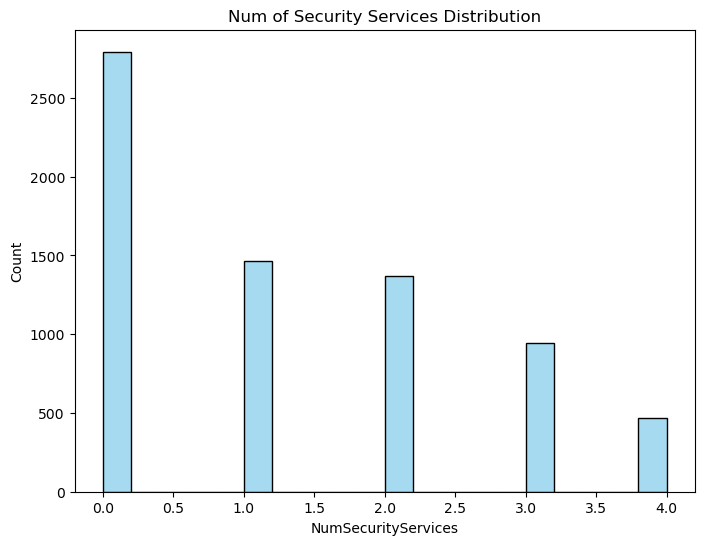

In [209]:
plt.figure(figsize=(8,6))
sns.histplot(df['NumSecurityServices'], color='skyblue')
plt.title("Num of Security Services Distribution")
plt.show()

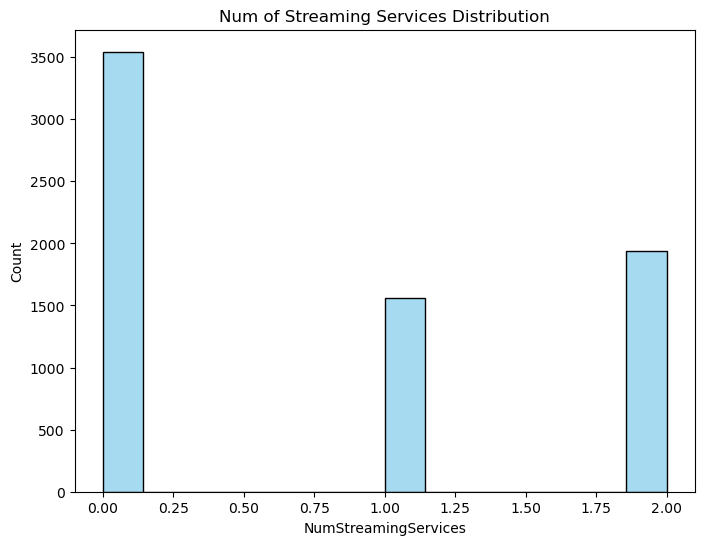

In [211]:
plt.figure(figsize=(8,6))
sns.histplot(df['NumStreamingServices'], color='skyblue')
plt.title("Num of Streaming Services Distribution")
plt.show()

### Edge cases
- Confirm no NaNs were introduced during the transformation.

In [213]:
df[['has_internet','NumSecurityServices','NumStreamingServices']].isna().sum()

has_internet            0
NumSecurityServices     0
NumStreamingServices    0
dtype: int64

## Validation of Newly Created Features

### Unique Values and Value Counts
- **has_internet**: Unique values [1 0], confirming binary nature.
- **NumSecurityServices**:
  - 0: 2793
  - 1: 1467
  - 2: 1372
  - 3: 941
  - 4: 470
- **NumStreamingServices**:
  - 0: 3544
  - 1: 1559
  - 2: 1940

### Consistency Checks
- **Condition 1**: For rows where `has_internet == 0`, all service counts (`NumSecurityServices`, `NumStreamingServices`) are 0 (14353 rows validated).
- **Condition 2**: For rows where `has_internet == 1`, service counts vary logically (0 to 4 for security, 0 to 2 for streaming), with no exceedances (14353 rows validated).

### Correlation Analysis
- Correlation Matrix:
  - `NumSecurityServices` vs. `NumStreamingServices`: 0.469844
  - `NumSecurityServices` vs. `churn`: -0.173061
  - `NumStreamingServices` vs. `churn`: 0.071162
  - `churn` vs. itself: 1.000000
- Insights: Moderate positive correlation between service types, negative correlation between security services and churn, slight positive correlation between streaming services and churn.

### Histogram Visualization
- Histograms confirm balanced distributions for `NumSecurityServices` and `NumStreamingServices`, with no extreme skewness.

### Edge Case:
- No NaNs were introduced as i checked above.
    
### Conclusion
Features are validated for consistency, logical ranges, and meaningful correlations, supporting their use in modeling.

# Feature Engineering
## Loading Data
I load the cleaned dataset saved from the EDA notebook, verifying its structure (7043 rows, 22 columns after initial drops) and ensuring no missing values remain post-imputation (e.g., `totalcharges` median fill). The initial feature set includes `seniorcitizen`, `partner`, `dependents`, `tenure`, `internetservice`, `onlinesecurity`, `onlinebackup`, `deviceprotection`, `techsupport`, `streamingtv`, `streamingmovies`, `contract`, `paperlessbilling`, `paymentmethod`, `monthlycharges`, `churn`, `tenure_group`, `MC_group`.

## Feature Engineering

### Creating has_internet Binary Indicator
I introduce a binary feature `has_internet` to simplify the dataset based on EDA findings. The "No Internet Service" category across `internetservice`, `onlinesecurity`, `techsupport`, `onlinebackup`, `deviceprotection`, `streamingtv`, and `streamingmovies` showed identical low churn rates (0.1875 to 0.0155), indicating redundancy. I map:
- `internetservice` values: "Fiber optic" or "DSL" → 1 (has internet), "No" → 0 (no internet).
This eliminates the need for separate "No Internet Service" categories in add-on features, reducing dimensionality while preserving the stable segment's behavior.

### Creating NumSecurityServices Feature
I derive `NumSecurityServices` to aggregate the count of security-related add-ons, reflecting their protective effect on churn (e.g., lower rates with `onlinesecurity` Yes: 0.3360 vs. No: 0.6161). I first map the features:
- `onlinesecurity`, `onlinebackup`, `deviceprotection`, `techsupport`: "Yes" → 1, "No" or "No Internet Service" → 0.
Then, I sum these binary values into `NumSecurityServices`, ranging from 0 (no services) to 4 (all services). This captures the combined retention impact of these features in a single metric.

### Creating NumStreamingServices Feature
I create `NumStreamingServices` to separately track streaming-related services (`streamingtv`, `streamingmovies`), as EDA showed higher churn with these (e.g., `streamingtv` Yes: 0.6491 vs. No: 0.5410), suggesting a distinct pattern. I apply the same mapping:
- `streamingtv`, `streamingmovies`: "Yes" → 1, "No" or "No Internet Service" → 0.
I sum these into `NumStreamingServices`, ranging from 0 to 2, allowing me to treat streaming services differently from security services due to their potential churn-increasing effect.

## Validation
I verify the new features:
- `has_internet`: Binary (0 or 1), correctly reflects `internetservice` categories.
- `NumSecurityServices`: Ranges 0-4, with counts aligning with individual feature sums.
- `NumStreamingServices`: Ranges 0-2, consistent with streaming feature combinations.
I check for missing values (none introduced) and ensure no data leakage (features based on pre-churn data).

## Updated Feature Set
- **Dropped Features**: `customerID`, `gender`, `phoneService`, `totalcharges`, `AvgMonthlyCost` (from EDA), `multiplelines`, `onlinesecurity`, `onlinebackup`, `deviceprotection`, `techsupport`, `streamingtv`, `streamingmovies`.
- **Retained and New Features**: `seniorcitizen`, `partner`, `dependents`, `tenure`, `has_internet`, `contract`, `paperlessbilling`, `paymentmethod`, `monthlycharges`, `churn`, `tenure_group`, `MC_group`, `NumSecurityServices`, `NumStreamingServices`.

## Next Steps
- **Preprocessing**: I will encode remaining categorical variables, scale numerical features, and perform train-test split.
- **Output**: I will save the preprocessed dataset for modeling in the next notebook.

## Dropping Redundant Features

- As after Creating NumSecurityServices and NumStreamingServices i will drop original ones.

In [119]:
cols_to_drop = ['onlinesecurity', 'onlinebackup','deviceprotection','techsupport','streamingtv','streamingmovies']
df.drop(columns=cols_to_drop, axis=1, inplace=True)

## Dropping Multiple lines As according to my Previous analysis

In [122]:
df.drop('multiplelines', axis=1, inplace=True)
## Final view
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   seniorcitizen         7043 non-null   int64  
 1   partner               7043 non-null   object 
 2   dependents            7043 non-null   object 
 3   tenure                7043 non-null   int64  
 4   internetservice       7043 non-null   object 
 5   contract              7043 non-null   object 
 6   paperlessbilling      7043 non-null   object 
 7   paymentmethod         7043 non-null   object 
 8   monthlycharges        7043 non-null   float64
 9   churn                 7043 non-null   int64  
 10  tenure_group          7043 non-null   object 
 11  MC_group              7043 non-null   object 
 12  has_internet          7043 non-null   int64  
 13  NumSecurityServices   7043 non-null   int64  
 14  NumStreamingServices  7043 non-null   int64  
dtypes: float64(1), int64(

## Final Feature Selection
- I mainly decided to pick tenure instead of tenure_group and monthlycharges instead of MC_group as they give more information and are more readable.
- But I think Mutual Information ranking should be tried to select final.

In [129]:
# Testing tenure vs. churn 
mi_tenure = mutual_info_classif(df[['tenure']], df['churn'])[0]

# Converting tenure_group to numerical codes for the MI test
df['tenure_group_code'] = df['tenure_group'].astype('category').cat.codes
mi_tenure_group = mutual_info_classif(df[['tenure_group_code']], df['churn'])[0]

print(f"MI Score for tenure: {mi_tenure:.4f}")
print(f"MI Score for tenure_group: {mi_tenure_group:.4f}")

# The feature with the higher MI score is the one I should keep.
if mi_tenure > mi_tenure_group:
    print("tenure is a better predictor.")
else:
    print("tenure_group is a better predictor.")

MI Score for tenure: 0.0671
MI Score for tenure_group: 0.0718
tenure_group is a better predictor.


In [131]:
# Testing monthlycharges vs. churn (numerical vs. categorical)
mi_monthlycharges = mutual_info_classif(df[['monthlycharges']], df['churn'])[0]

# Convert MC_group to numerical codes for the MI test
df['MC_group_code'] = df['MC_group'].astype('category').cat.codes
mi_mc_group = mutual_info_classif(df[['MC_group_code']], df['churn'])[0]

print(f"MI Score for monthlycharges: {mi_monthlycharges:.4f}")
print(f"MI Score for MC_group: {mi_mc_group:.4f}")

if mi_monthlycharges > mi_mc_group:
    print("monthlycharges is a better predictor.")
else:
    print("MC_group is a better predictor.")

MI Score for monthlycharges: 0.0432
MI Score for MC_group: 0.0202
monthlycharges is a better predictor.


## Preparing for Modeling

### What to Keep
- As I have `tenure` and `tenure_group` and similarly `monthlycharges` and `MC_group` but i have to pick one which is more informative.
- Most of the time raw features are more predictive specially for tree-based models. But for linear models these groups like features are more better.
- But after Mutual Information test I found that tenure_group is more predictive then tenure but monthlycharges still better then its grouping.
- So, I decided to keep 2 datasets, where the main data will contains raw features as tree models don't rely on linear patterns. And I will kept data with bucketed version for Linear Models.
- I also need to preprocess 2 different pipelines but still I will be using this approach.

### Mapping Categorical Columns

In [149]:
mapping = {'Yes':1, 'No':0}
cols_to_map = ['partner','dependents','paperlessbilling']
for col in cols_to_map:
    df[col] = df[col].map(mapping)

In [155]:
## preview
df[['tenure','partner','dependents','paperlessbilling']].sample(3)

,tenure,partner,dependents,paperlessbilling
1079,3,1,1,1
2491,42,1,0,0
2672,27,0,0,0


## Feature Engineering and Preprocessing

### Dropping Multiple Lines
I finalized the drop of `multiplelines` as decided in the EDA (low MI score of 0.000801), removing it from the dataset to reduce noise and align with prior feature selection decisions.

### Binary Mapping
I mapped categorical binary features to 0/1 for simplicity and consistency:
- `partner`: "No" → 0, "Yes" → 1.
- `dependents`: "No" → 0, "Yes" → 1.
- `paperlessbilling`: "No" → 0, "Yes" → 1.

### Final Feature Selection
I faced a decision between `tenure` and `tenure_group`, and between `monthlycharges` and `MC_group`. To resolve this, I performed Mutual Information (MI) analysis:
- MI Scores:
  - `tenure`: 0.0671
  - `tenure_group`: 0.0718
  - `monthlycharges`: 0.0432
  - `MC_group`: 0.0202
- `tenure_group` outperformed `tenure`, and `monthlycharges` outperformed `MC_group`, indicating higher predictive power.
- Considering model types, I noted that raw features (`tenure`, `monthlycharges`) are better suited for tree-based models (e.g., Random Forest) due to their ability to capture non-linear relationships, while grouped features (`tenure_group`, `MC_group`) might enhance linear models (e.g., Logistic Regression) by reducing complexity.
- **Decision**: I will create two separate DataFrames:
  - **Raw Features DataFrame**: Retains `tenure` and `monthlycharges`.
  - **Grouped Features DataFrame**: Retains `tenure_group` and `MC_group`.
- I plan to train tree-based models on the raw features dataset and test linear models on both datasets to determine where they perform better.

## Upcoming Preprocessing Steps in modeling Notebook
- **Encoding Categorical Variables**:
  - **One-Hot Encoding**: I will apply one-hot encoding to `internetservice` and `paymentmethod` as they lack a clear ordinal relationship (e.g., Fiber Optic vs. DSL, Electronic Check vs. Mailed Check).
  - **Ordinal Encoding**: I will use ordinal encoding for `contract` (Month-to-month < One year < Two year), `tenure_group` (0-12 < 13-24 < 25-48 < 49-72 < 72+), and `MC_group` (Low < Mid < High) to preserve their ordered nature.
- **Scaling Numerical Features**: I will standardize `tenure` and `monthlycharges` in the raw dataset using Standard Scaler or Mix Max Scaler.
- **Train-Test Split**: I will split both datasets into training (80%) and testing (20%) sets, stratifying on `churn` to maintain class balance.

## Validation and Output
I will validate the encoded and scaled features (e.g., check shapes, distribution shifts) and save both preprocessed datasets for modeling in the next notebook.

## Next Steps
- Saving Seperate Datasets for raw and grouped features
- Proceed to the modeling notebook to train tree-based models on the raw features dataset and linear models on both datasets, comparing performance.
- Evaluate results and refine feature sets if necessary.

### Dropping Grouped Features codes
- These are the codes that i calculated through pandas for MI ranking. But, now I am dropping.

In [172]:
df.drop(columns=['tenure_group_code','MC_group_code'], axis=1, inplace=True)

### Saving Seperate Data for Both featues

In [175]:
df_raw = df.drop(columns=['tenure_group','MC_group'], axis=1).copy()
df_grouped = df.drop(columns=['tenure','monthlycharges'],axis=1).copy()

### Confirming that Both are Clean

In [178]:
print("Raw Dataset:")
display(df_raw.head())
df_raw.info()
print(df_raw.isna().sum())

Raw Dataset:


,seniorcitizen,partner,dependents,tenure,internetservice,contract,paperlessbilling,paymentmethod,monthlycharges,churn,has_internet,NumSecurityServices,NumStreamingServices
0,0,1,0,1,DSL,Month-to-month,1,Electronic check,29.85,0,1,1,0
1,0,0,0,34,DSL,One year,0,Mailed check,56.95,0,1,2,0
2,0,0,0,2,DSL,Month-to-month,1,Mailed check,53.85,1,1,2,0
3,0,0,0,45,DSL,One year,0,Bank transfer (automatic),42.30,0,1,3,0
4,0,0,0,2,Fiber optic,Month-to-month,1,Electronic check,70.70,1,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   seniorcitizen         7043 non-null   int64  
 1   partner               7043 non-null   int64  
 2   dependents            7043 non-null   int64  
 3   tenure                7043 non-null   int64  
 4   internetservice       7043 non-null   object 
 5   contract              7043 non-null   object 
 6   paperlessbilling      7043 non-null   int64  
 7   paymentmethod         7043 non-null   object 
 8   monthlycharges        7043 non-null   float64
 9   churn                 7043 non-null   int64  
 10  has_internet          7043 non-null   int64  
 11  NumSecurityServices   7043 non-null   int64  
 12  NumStreamingServices  7043 non-null   int64  
dtypes: float64(1), int64(9), object(3)
memory usage: 715.4+ KB
seniorcitizen           0
partner                 0
dependents  

In [180]:
print("\nGrouped Dataset:")
display(df_grouped.head())
df_grouped.info()
print(df_grouped.isna().sum())


Grouped Dataset:


,seniorcitizen,partner,dependents,internetservice,contract,paperlessbilling,paymentmethod,churn,tenure_group,MC_group,has_internet,NumSecurityServices,NumStreamingServices
0,0,1,0,DSL,Month-to-month,1,Electronic check,0,0-12 Months,Low,1,1,0
1,0,0,0,DSL,One year,0,Mailed check,0,25-48 Months,Mid,1,2,0
2,0,0,0,DSL,Month-to-month,1,Mailed check,1,0-12 Months,Mid,1,2,0
3,0,0,0,DSL,One year,0,Bank transfer (automatic),0,25-48 Months,Low,1,3,0
4,0,0,0,Fiber optic,Month-to-month,1,Electronic check,1,0-12 Months,Mid,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   seniorcitizen         7043 non-null   int64 
 1   partner               7043 non-null   int64 
 2   dependents            7043 non-null   int64 
 3   internetservice       7043 non-null   object
 4   contract              7043 non-null   object
 5   paperlessbilling      7043 non-null   int64 
 6   paymentmethod         7043 non-null   object
 7   churn                 7043 non-null   int64 
 8   tenure_group          7043 non-null   object
 9   MC_group              7043 non-null   object
 10  has_internet          7043 non-null   int64 
 11  NumSecurityServices   7043 non-null   int64 
 12  NumStreamingServices  7043 non-null   int64 
dtypes: int64(8), object(5)
memory usage: 715.4+ KB
seniorcitizen           0
partner                 0
dependents              0
internetservi

### Saving Both final Datasets

In [183]:
df_raw.to_csv("final_data_raw.csv", index=False)
df_grouped.to_csv("final_data_grouped.csv", index=False)

## Summary of Notebook Activities
I loaded the processed dataset from the EDA phase (7043 rows, 20 columns after initial drops). Based on EDA insights (e.g., churn patterns, correlations, MI scores), I performed feature engineering to enhance predictive power and reduce redundancy:
- **Created `has_internet` Binary Indicator**: Mapped `internetservice` to 1 (Fiber optic or DSL) or 0 (No), eliminating the "No Internet Service" category redundancy identified in EDA (identical low churn rates across add-ons).
- **Created `NumSecurityServices`**: Mapped `onlinesecurity`, `onlinebackup`, `deviceprotection`, `techsupport` to 1 (Yes) or 0 (No or No Internet Service), then summed to count security add-ons (range 0-4), capturing their protective effect on churn (lower rates with more services).
- **Created `NumStreamingServices`**: Mapped `streamingtv`, `streamingmovies` to 1 (Yes) or 0 (No or No Internet Service), then summed (range 0-2), treating streaming separately due to higher churn patterns in EDA.
- **Dropped `multiplelines`**: Low MI score (0.000801) from EDA confirmed negligible predictive value, despite significant Chi-square (χ² = 11.33, p = 0.0035).
- **Binary Mapping**: Converted `partner`, `dependents`, `paperlessbilling` to 0/1 for consistency.
- **Final Feature Selection and DataFrames**: Created two separate DataFrames based on MI analysis (e.g., `tenure_group` > `tenure`, `monthlycharges` > `MC_group`):
  - **Raw Features DataFrame**: Retained `tenure` and `monthlycharges` (dropped `tenure_group`, `MC_group`), suited for tree-based models.
  - **Grouped Features DataFrame**: Retained `tenure_group` and `MC_group` (dropped `tenure`, `monthlycharges`), potentially better for linear models.
  - Common retained features in both: `seniorcitizen`, `partner`, `dependents`, `internetservice`, `contract`, `paperlessbilling`, `paymentmethod`, `churn`, `has_internet`, `NumSecurityServices`, `NumStreamingServices`.
- **Dropped Feature Codes**: Removed code snippets used for MI ranking from the EDA phase, as they are no longer needed here.

I validated new features (e.g., checked ranges, distributions) and confirmed no missing values or leakage.

## Key Insights from EDA Integration
- Churn decreases monotonically with tenure across segments, with early tenure (0-12 months) as the highest risk (e.g., 48.3% overall churn rate).
- Contract type is a top predictor (MI 0.0985), with month-to-month at high risk (51.9% at 0-12 months).
- Fiber Optic has elevated churn (70.3% at 0-12 months) vs. DSL (40.9%) or No Internet (18.8%).
- Add-ons like security services reduce churn, while streaming services may increase it.
- Payment methods show variation, with Electronic Check at highest risk (63.1% at 0-12 months).

These insights guided feature engineering (e.g., `has_internet` for No Internet stability, separate summation for security and streaming).

## Next Steps
- **Modeling Notebook**: I will move to a new notebook for model training and evaluation. I plan to use pipelines for all steps (encoding, scaling, modeling) to ensure reproducibility.
  - Encoding: One-hot for `internetservice` and `paymentmethod`; ordinal for `contract`, `tenure_group`, `MC_group`.
  - Scaling: StandardScaler for numerical features.
  - Models: Train tree-based (e.g., Random Forest) on raw DataFrame; test linear (e.g., Logistic Regression) on both raw and grouped DataFrames; compare metrics (e.g., accuracy, F1-score).
  - Evaluation: Use cross-validation, confusion matrices, and feature importance to refine.